In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from matplotlib import cm

In [2]:
AA = list(pp.aa1)

In [3]:
DATA = 'data/'

In [4]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

In [5]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [6]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [7]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [9]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(join(DATA, 'structure'), f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [10]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [11]:
def GetPercentage(percentage, which, data, return_score=False):
    """Return set with top or bottom percentage of positions according to functional data. 
    Parameters:
        percentage (float): between 0 and 1, percentage of positions that we want.
        which (str): 'highest', 'lowest'
        data (dataframe): functional data to consider mean of
        return_score (bool): If True, return list of tuples with mean value and position
    Returns:
        Set of positions.
    """
    functional_mean = data.mean()
    positions = list(data.columns)
    pairs = [(functional_mean[pos], pos) for pos in positions] 
    pairs.sort(key = lambda x:x[0]) 
    if which == 'highest': 
        pairs.reverse() 
    n = int(len(positions)*percentage)
    if return_score:
        return [pair for pair in pairs[:n]]
    else:
        return set([pair[1] for pair in pairs[:n]])

In [12]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=9.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [13]:
def ToPercentage(a,b):
    """Return percentage form of a/b, if b != 0. If given set or list, use len of. 
    If string, return formatted percentage, else float."""
    x = a if type(a) == int or type(a) == float else len(a)
    y = b if type(b) == int or type(b) == float else len(b)
    
    if y == 0:
        return np.nan
    else:
        return round(100*x/y,1)

In [93]:
def GetScores(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True):
    """Return accuracy, coverage and prediction percentage scores. Returns list of lists, [accuracy, coverage,
    predper] for each protein and the mean, if mean == True """
    which_scores = ['Accuracy', 'Coverage', 'Prediction']
    scores = {score:[] for score in which_scores}
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)
    
        scores['Coverage'].append(ToPercentage(how_many, funct_extremes))
        scores['Accuracy'].append(ToPercentage(how_many, network_extremes))
        scores['Prediction'].append(ToPercentage(network_extremes, positions))
        
    if mean:
        for score in which_scores:
            scores[score].append(round(np.mean(scores[score]), 2))
            
    return scores

In [94]:
def GetScoresGain(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True):
    """Return accuracy, coverage and prediction percentage scores. Returns dict with list of three lists, containing 
    the values for each of the 5 proteins and if mean == True, the mean."""
    which_scores = ['Accuracy', 'Coverage', 'Prediction']
    scores = {score:[] for score in which_scores}
    for protein in proteins:
        
        network_extremes_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        total_positions = functional_data[protein].columns
        funct_extremes = GetPercentage(functional_percentage, 'highest', functional_data[protein])
        network_extremes = set([pos for pos in total_positions if pos not in network_extremes_loss])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)
    
        scores['Coverage'].append(ToPercentage(how_many, funct_extremes))
        scores['Accuracy'].append(ToPercentage(how_many, network_extremes))
        scores['Prediction'].append(ToPercentage(network_extremes, positions))
        
    if mean:
        for score in which_scores:
            scores[score].append(round(np.mean(scores[score]), 2))
    return scores

## Loss predictions

In [69]:
def GetBoxen(data):
    '''Return boxen plot with extra markers for threshold 9.'''
    # Get single df with data for all proteins and mean
    dfs = []
    for protein in data.keys():
        df = pd.DataFrame(data[protein], columns=['Threshold','Score', 'Name'])
        df['Protein'] = protein
        dfs.append(df)
    df = pd.concat(dfs)
    d = dict(zip(proteins, protein_names))
    df['Protein'] = df['Protein'].replace(d)
    
    # Plot
    g = sns.catplot(x='Name', y='Score', data=df, col='Protein', col_wrap=3,
            col_order=df.Protein.unique(), kind='boxen')
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    x = [0, 1 , 2] 
    for i, protein in enumerate(df.Protein.unique()):
        y = df[(df.Protein==protein) & (df.Threshold==9.)]['Score'].values
        g.axes[i].scatter(x=x, y=y, c='red', zorder=3, s=50, marker='d')
    X = plt.scatter([], [], marker='d', c='red', label='Scores for threshold 9')
    plt.legend(frameon=False)
    return g

In [87]:
### make one dataframe per protein and one for the mean, with columns accuracy, coverage, predper; thresholds as index
## maximizing accuracy
proteins2 = proteins+['Mean']
data_accuracy = {protein:[] for protein in proteins2}
which_scores = ['Accuracy', 'Coverage', 'Prediction']

for thresh in thresholds:
    scores = GetScores(0.4, 4, [1.5]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_accuracy[protein].append([thresh, scores[name][i], name])

In [16]:
## maximizing coverage
data_coverage = {protein:[] for protein in proteins2}

for thresh in thresholds:
    scores = GetScores(0.4, 2, [1]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_coverage[protein].append([thresh, scores[name][i], name])

In [17]:
## maximizing both
data_both = {protein:[] for protein in proteins2}

for thresh in thresholds:
    scores = GetScores(0.4, 2, [1.5]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_both[protein].append([thresh, scores[name][i], name])

In [39]:
### make one dataframe per protein and one for the mean, with columns accuracy, coverage, predper; thresholds as index
## maximizing accuracy
proteins2 = proteins+['Mean']
data_accuracy_4 = {protein:[] for protein in proteins2}
which_scores = ['Accuracy', 'Coverage', 'Prediction']

for thresh in thresholds[10:]:
    scores = GetScores(0.4, 4, [1.5]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_accuracy_4[protein].append([thresh, scores[name][i], name])

In [90]:
improvement = {protein:[] for protein in proteins2}
for protein in data_accuracy.keys():
    for i in data_accuracy[protein]:
        if i[2] == 'Accuracy':
            improvement[protein].append([i[0], round(i[1]/40, 2), 'Improvement'])

In [96]:
data_improvement = {protein: data_accuracy[protein]+improvement[protein] for protein in proteins2}

In [169]:
def facetgrid_two_axes(*args, **kwargs):
    data = kwargs.pop('data')
    dual_axis = kwargs.pop('dual_axis')
    alpha = kwargs.pop('alpha', 0.2)
    kwargs.pop('color')
    ax = plt.gca()
    ax.set_ylim(0,100)
    if dual_axis:
        ax2 = ax.twinx()
        ax2.set_ylabel('Improvement')
        ax2.set_ylim(0,3)

In [174]:
def GetBoxen2(data):
    '''Return boxen plot with extra markers for threshold 9.'''
    # Get single df with data for all proteins and mean
    dfs = []
    for protein in data.keys():
        df = pd.DataFrame(data[protein], columns=['Threshold','Score', 'Name'])
        df['Protein'] = protein
        dfs.append(df)
    df = pd.concat(dfs)
    d = dict(zip(proteins, protein_names))
    df['Protein'] = df['Protein'].replace(d)
    df = df[df['Name'] != 'Prediction']
    
    # Rescale improvement 
    df['Score'][df['Name'] == 'Improvement'] = df['Score'][df['Name'] == 'Improvement'].apply(
                                                                            lambda x: round(100*x/3, 2))
    
    # Plot
    g = sns.catplot(x='Name', y='Score', data=df, col='Protein', col_wrap=3,
            col_order=df.Protein.unique(), kind='boxen')   
    (g.map_dataframe(facetgrid_two_axes, dual_axis=True)
         .set_axis_labels("Name", "Score"))
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}') 

    x = [0, 1 , 2] 
    for i, protein in enumerate(df.Protein.unique()):
        y = df[(df.Protein==protein) & (df.Threshold==9.)]['Score'].values
        g.axes[i].scatter(x=x, y=y, c='red', zorder=3, s=50, marker='d')
    X = plt.scatter([], [], marker='d', c='red', label='Scores for threshold 9')
    plt.legend(frameon=False)
    return g

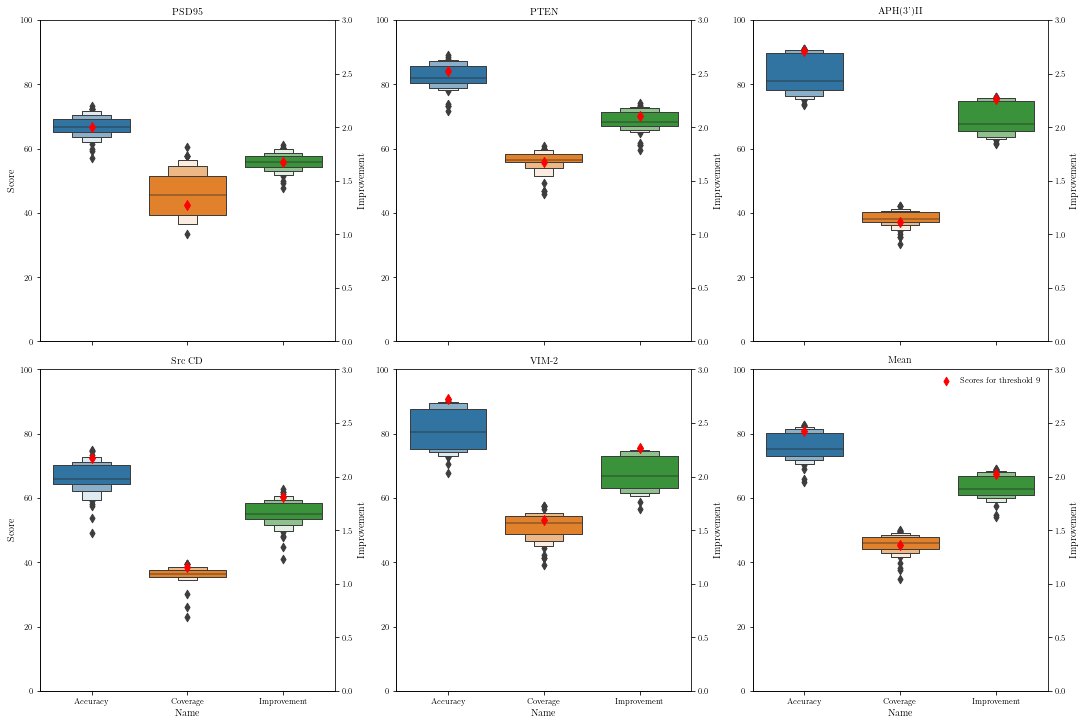

In [175]:
## En lugar de prediction percentage, incluir el improvement, pero no sé cómo poner el otro eje (improvement está 
## reescalado para un eje de 0 a 3)
GetBoxen2(data_improvement)

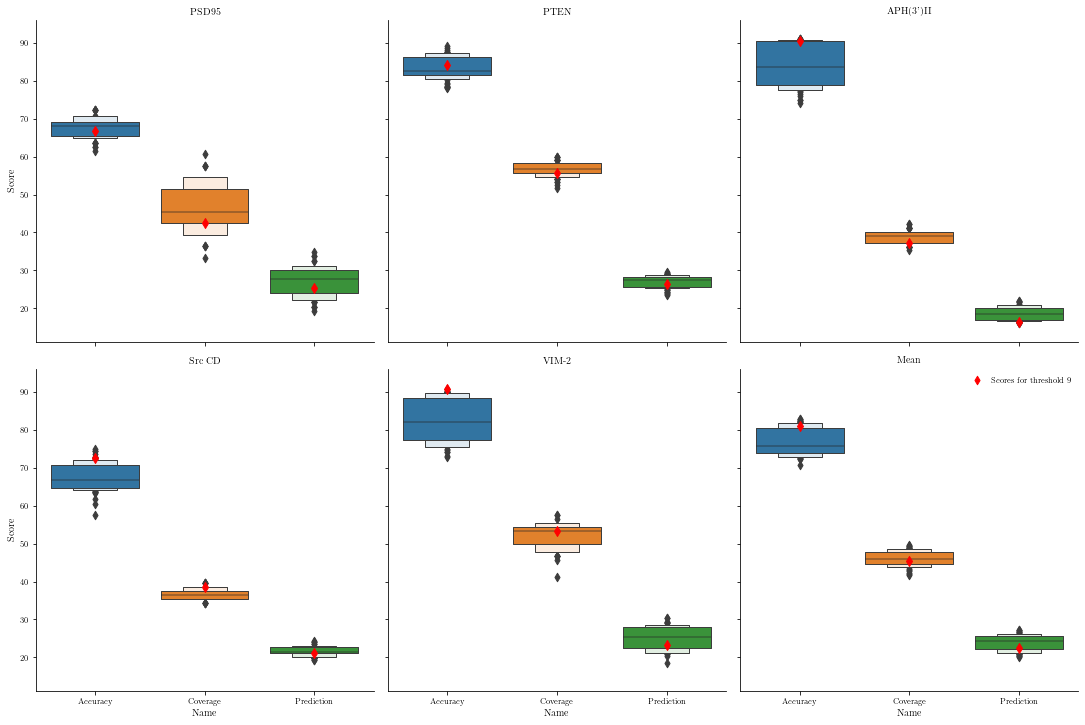

In [40]:
### Incluir solo los datos para thresholds 4-10? Que son los que vimos que tenian correlaciones parecidas
### Se pierden algunos outliers, pero no cambia mucho 
GetBoxen(data_accuracy_4)

## Loss plots

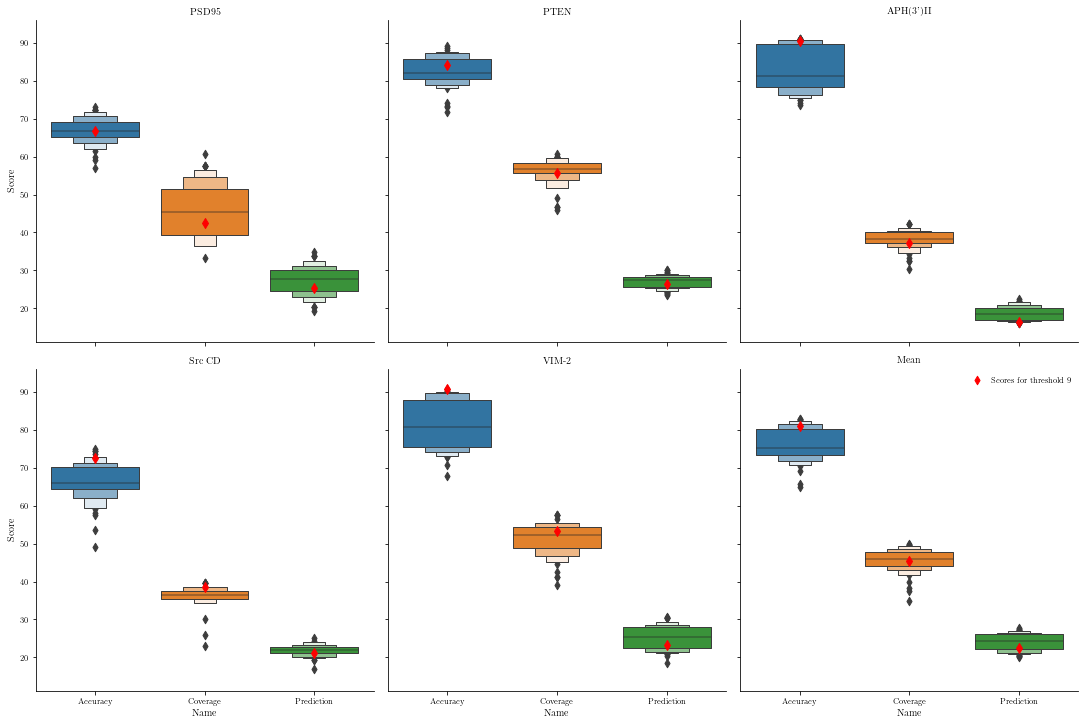

In [43]:
g = GetBoxen(data_accuracy)
g.savefig("figures/box_accuracy")

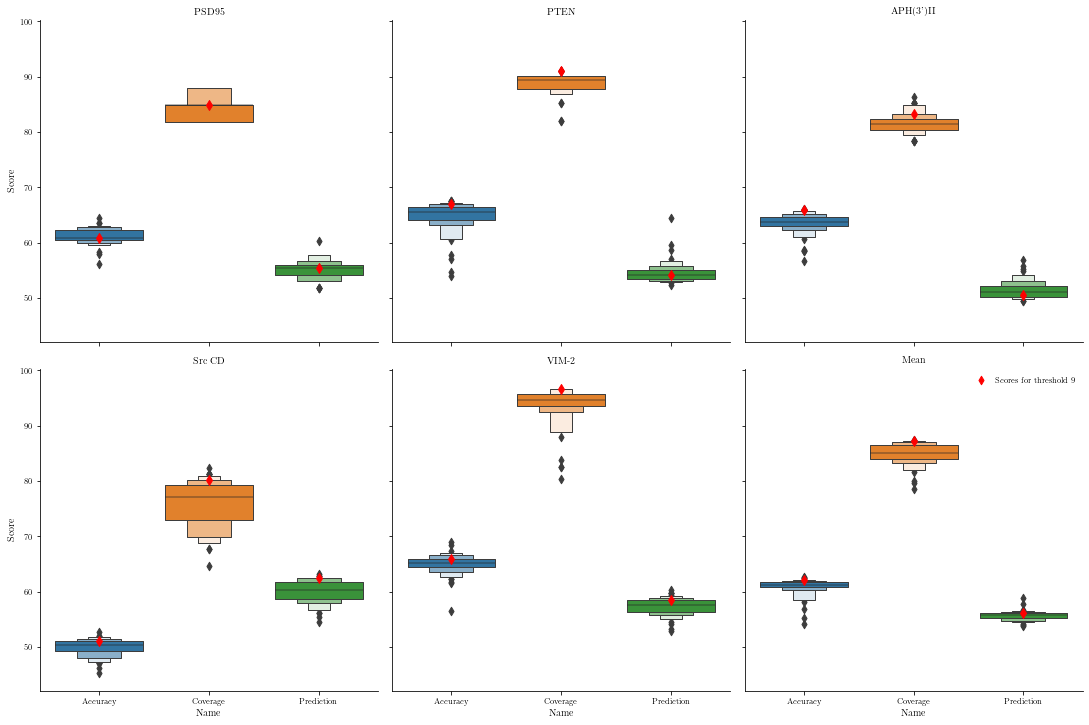

In [23]:
g = GetBoxen(data_coverage)
g.savefig("figures/box_coverage")

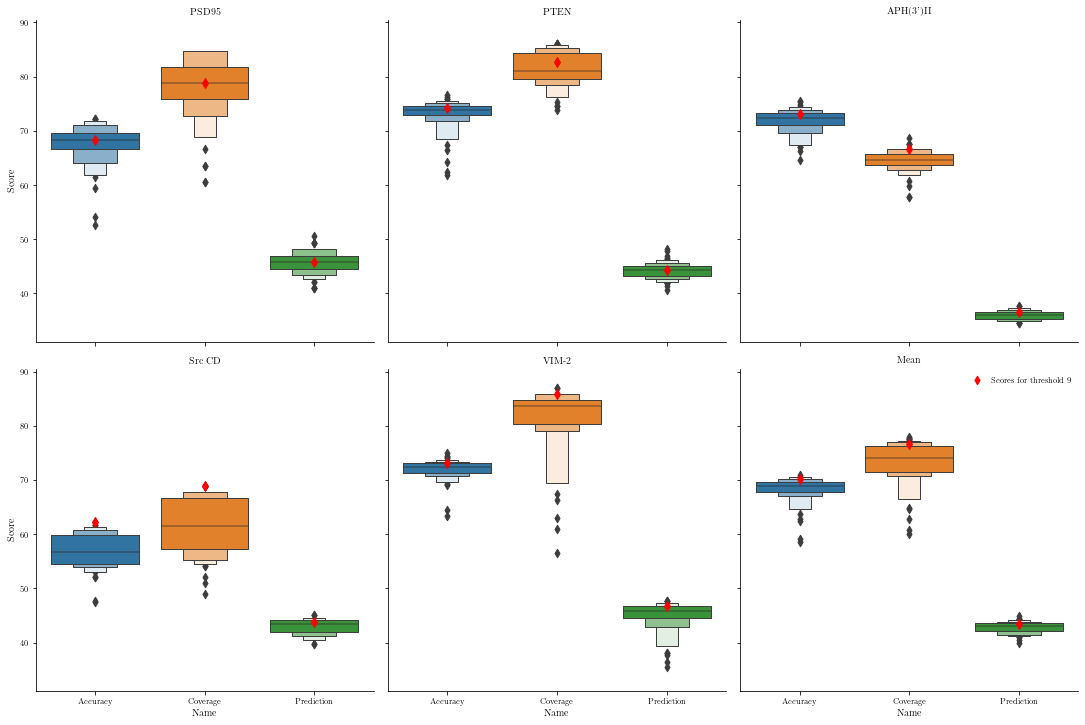

In [24]:
g = GetBoxen(data_both)
g.savefig("figures/box_both")

## Gain Predictions

In [26]:
### make one dataframe per protein and one for the mean, with columns accuracy, coverage, predper; thresholds as index
## maximizing accuracy
proteins2 = proteins+['Mean']
data_accuracy_gain = {protein:[] for protein in proteins2}
which_scores = ['Accuracy', 'Coverage', 'Prediction \\%']

for thresh in thresholds:
    scores = GetScoresGain(0.4, 1, [1]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_accuracy_gain[protein].append([thresh, scores[name][i], name])

In [32]:
## maximizing coverage
data_coverage_gain = {protein:[] for protein in proteins2}

for thresh in thresholds:
    scores = GetScoresGain(0.4, 3, [1]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_coverage_gain[protein].append([thresh, scores[name][i], name])

In [33]:
## maximizing both
data_both_gain = {protein:[] for protein in proteins2}

for thresh in thresholds:
    scores = GetScoresGain(0.4, 2, [1]*4, thresh=thresh)
    for name in which_scores:
        for i,protein in enumerate(proteins2):
            # add lines [thresh, score, type]
            data_both_gain[protein].append([thresh, scores[name][i], name])

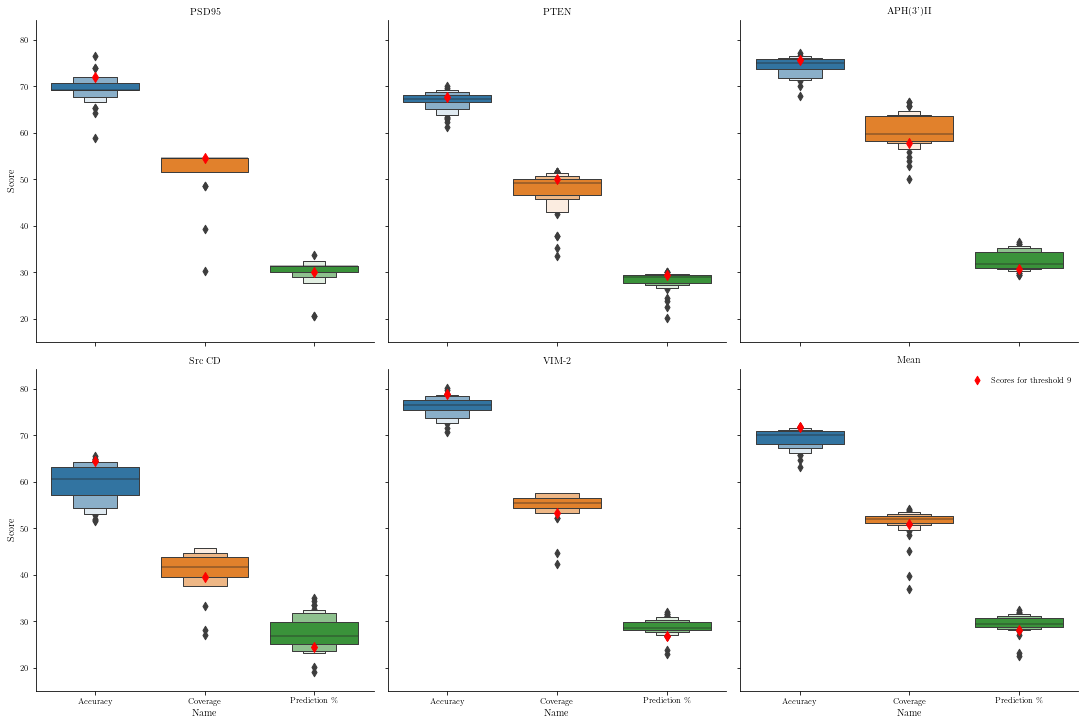

In [31]:
g = GetBoxen(data_accuracy_gain)
g.savefig("figures/box_accuracy_gain")

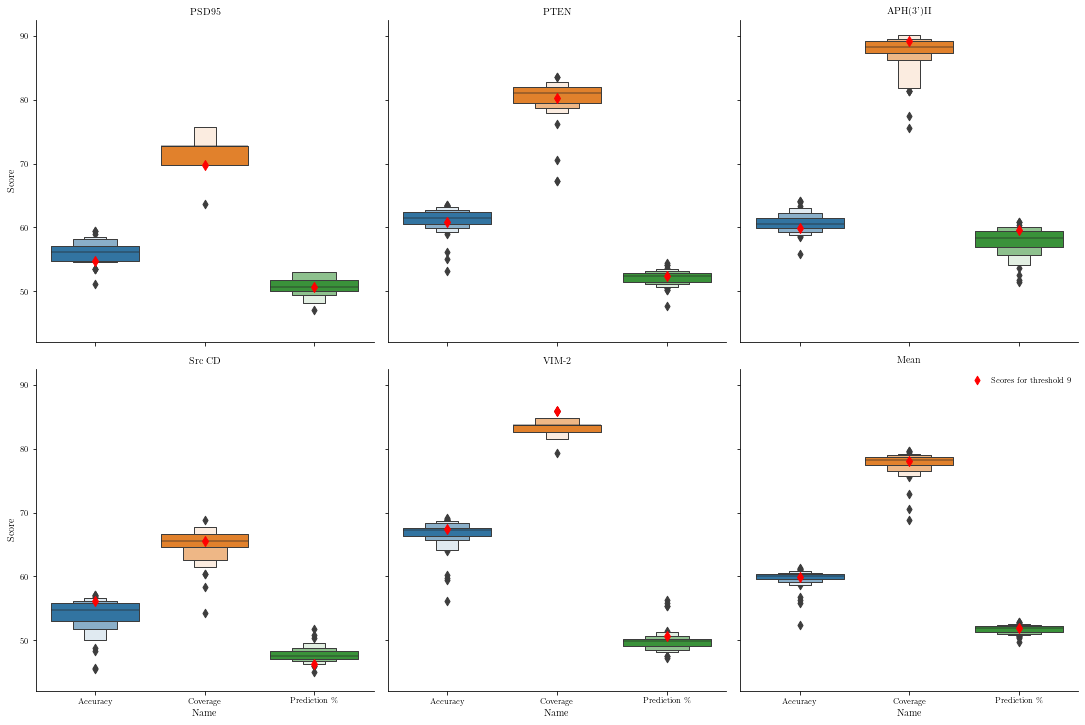

In [34]:
g = GetBoxen(data_coverage_gain)
g.savefig("figures/box_coverage_gain")

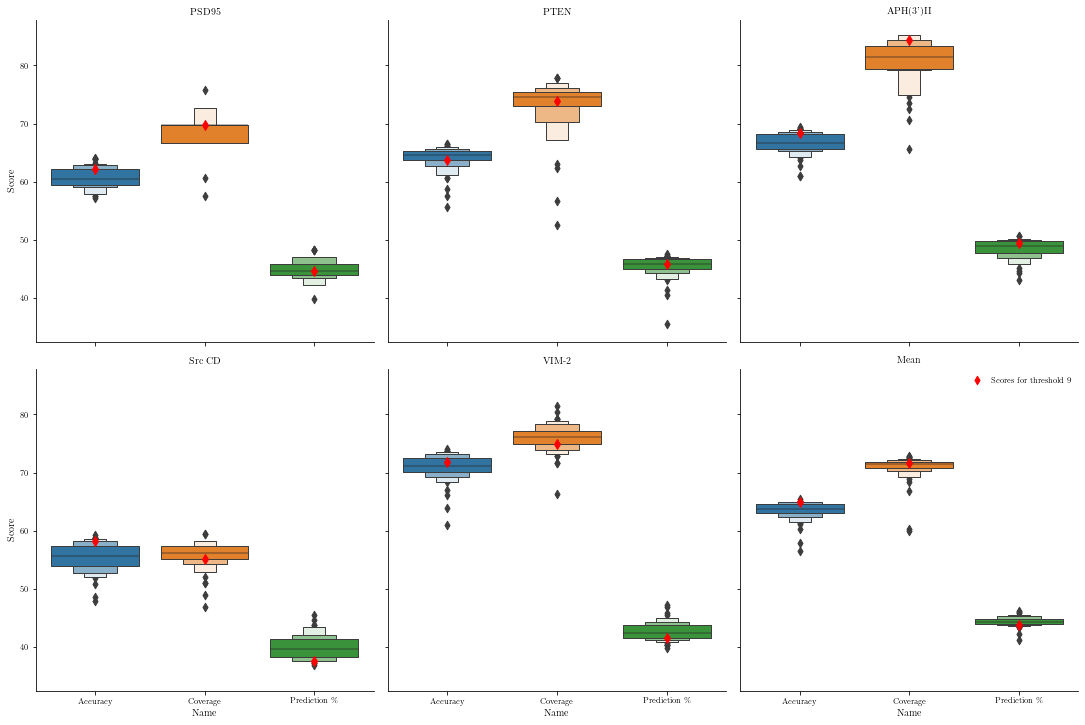

In [35]:
g = GetBoxen(data_both_gain)
g.savefig("figures/box_both_gain")